In [1]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GEVMLE_ts

In [14]:
import pymc as pm
import pymc_experimental.distributions as pmx
import arviz as az

In [3]:
df_hourly = pd.read_csv('../ewr_hourly_prcp.csv',parse_dates=['valid'],usecols=['valid','precip_in'])
df_hourly = df_hourly.rename(columns={'valid':'datetime'})
df_hourly['date'] = df_hourly['datetime'].dt.date
df_hourly['time'] = df_hourly['datetime'].dt.time

In [4]:
def ts_interpolate(ts):
    dt_start = ts.index.min()
    dt_end = ts.index.max()
    dt_range = pd.date_range(dt_start,dt_end)
    return ts.reindex(dt_range,fill_value=0.0)

In [5]:
#max hourly precipitation per day
ts_hourly_max = df_hourly.groupby(['date'])['precip_in'].max()
ts_hourly_max = ts_interpolate(ts_hourly_max)

In [6]:
ts_blockmaxima = ts_hourly_max.loc['1949-01-01':'2022-12-31'].copy() #we only want full years.
ts_blockmaxima = ts_blockmaxima.to_frame("value")
ts_blockmaxima["year"] = ts_blockmaxima.index.year
ts_blockmaxima = ts_blockmaxima.groupby("year")["value"].max()

In [8]:
GEV_hourly = GEVMLE_ts()
GEV_hourly.fit(ts_hourly_max)
GEV_hourly.get_params()

{'mu': 0.9219242941961374,
 'sigma': 0.29791060799659713,
 'xi': 0.16623019437413705}

In [ ]:
"""
Prior Distributions:

"""

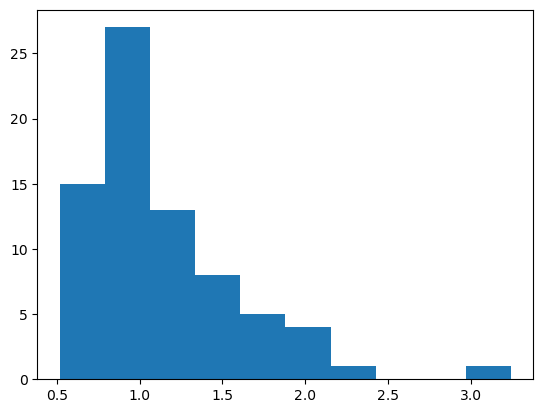

In [44]:
plt.hist(ts_blockmaxima,10);

In [20]:
data = ts_blockmaxima.values

In [53]:
p = 0.1

with pm.Model() as model:
    # Priors
    μ = pm.Normal("μ", mu=1.0, sigma=0.25)
    σ = pm.HalfNormal("σ", sigma=0.5)
    # ξ = pm.Normal("ξ", mu=0.0, sigma=0.1)
    # ξ = pm.TruncatedNormal("ξ", mu=0, sigma=0.2, lower=-0.5, upper=0.5)
    ξ = pm.HalfNormal("ξ", sigma=0.1)
 

    # Estimation
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=data)
    # Return level
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

In [54]:
idata = pm.sample_prior_predictive(samples=1000, model=model)

Sampling: [gev, μ, ξ, σ]


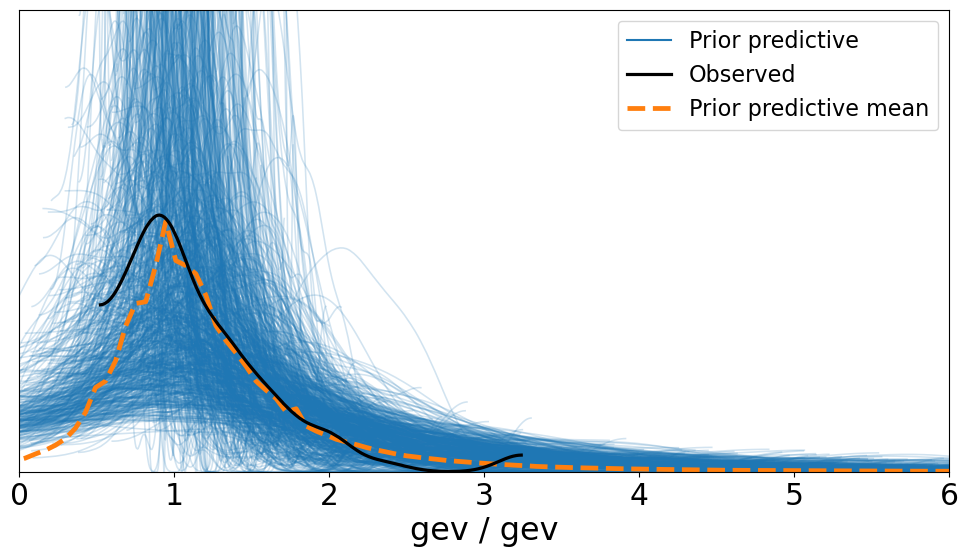

In [55]:
az.plot_ppc(idata, group="prior", figsize=(12, 6))
ax = plt.gca()
ax.set_xlim([0, 6])
ax.set_ylim([0, 2]);

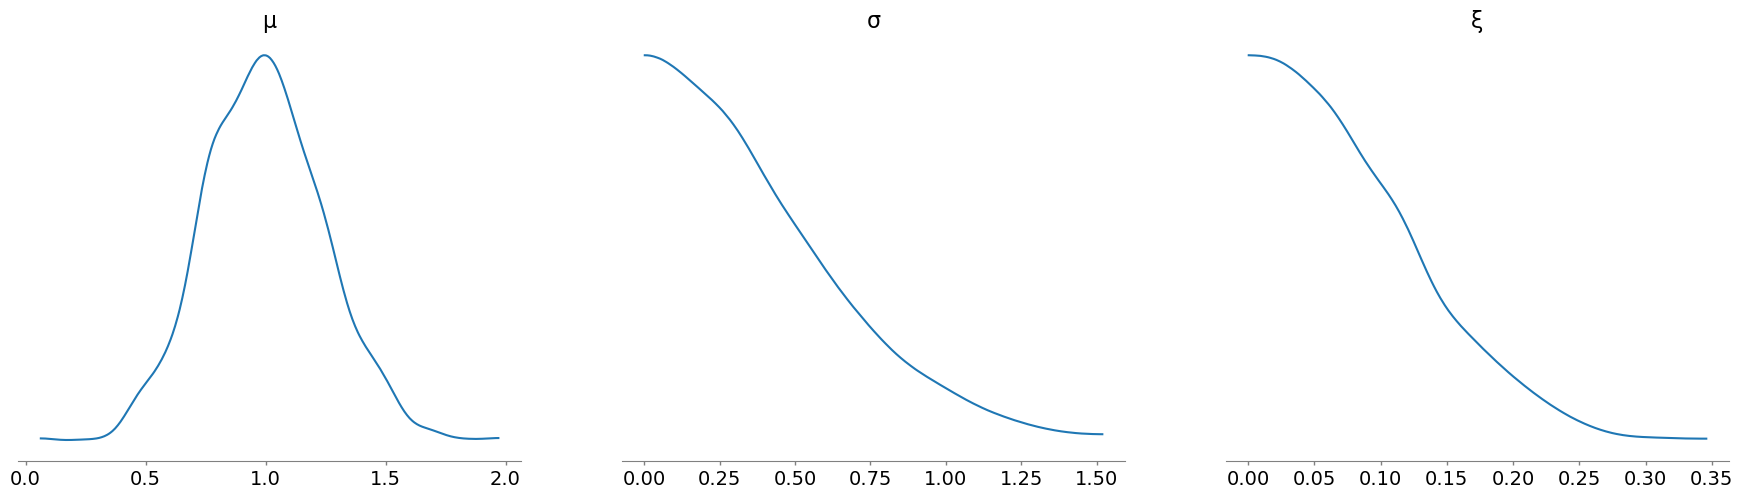

In [56]:
az.plot_posterior(
    idata, group="prior", var_names=["μ", "σ", "ξ"], hdi_prob="hide", point_estimate=None
);

In [60]:
with model:
    trace = pm.sample(
        5000,
        # cores=4,
        # chains=4,
        # tune=2000,
        # initvals={"μ": -0.5, "σ": 1.0, "ξ": -0.1},
        target_accept=0.98,
    )
# add trace to existing idata object
idata.extend(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


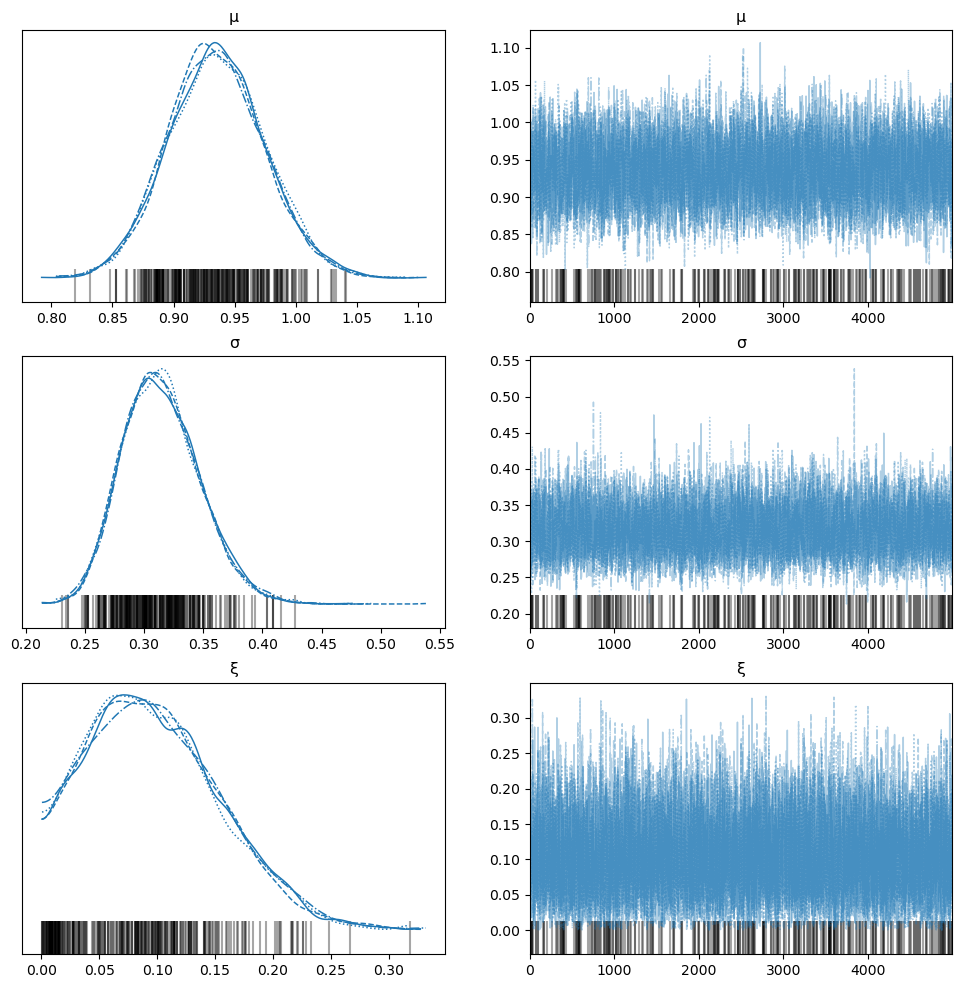

In [61]:
az.plot_trace(idata, var_names=["μ", "σ", "ξ"], figsize=(12, 12));